In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper # Stop the optimization before running out of a fixed budget of time.
from skopt.callbacks import DeltaXStopper # Stop the optimization If the last two positions at which the objective has been evaluated are less than delta

from sklearn.metrics import (
    confusion_matrix, accuracy_score, recall_score, 
    precision_score, log_loss, roc_curve, 
    auc, f1_score, roc_auc_score, 
    balanced_accuracy_score,
)

from skopt.space import Integer, Real
from sklearn import preprocessing

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import classification_report

In [2]:
dataset_path = "../../accidentes-dummies-fc.csv"
scaled_dataset_path = "../../accidentes-dummies-fc-std_scaled.csv"
final_dataset_path = "../../accidentes-dummies-fc-no-missings.csv"
wind_chill_model_filename = "../models/wind_chill_model.sav"
precipitation_model_filename = "../models/precipitation_model.sav"
wind_speed_model_filename = "../models/wind_speed_model.sav"

features_selected = []
random_state = 546565

In [3]:
accidentes_df = pd.read_csv(dataset_path)

scaler = StandardScaler()
columns = [
    "Start_x", "Start_y", "Start_z", 
    "Distance", "Temperature", "Wind_Chill", 
    "Humidity", "Pressure", "Visibility", 
    "Environment_Influence"
]
accidentes_df[columns] = scaler.fit_transform(accidentes_df[columns]) 
accidentes_df.to_csv(scaled_dataset_path, index=False)

print(accidentes_df[columns].mean(axis = 0))
print(accidentes_df[columns].std(axis = 0))

Start_x                 -1.433172e-16
Start_y                  2.417355e-16
Start_z                 -1.447967e-17
Distance                -2.515202e-17
Temperature             -7.088726e-16
Wind_Chill              -5.016140e-16
Humidity                -1.578166e-16
Pressure                 3.269534e-14
Visibility               5.841383e-16
Environment_Influence    4.475925e-16
dtype: float64
Start_x                  1.0
Start_y                  1.0
Start_z                  1.0
Distance                 1.0
Temperature              1.0
Wind_Chill               1.0
Humidity                 1.0
Pressure                 1.0
Visibility               1.0
Environment_Influence    1.0
dtype: float64


In [4]:
accidentes_df = pd.read_csv(scaled_dataset_path)
accidentes_wind_chill_df = accidentes_df.copy(deep=True)
accidentes_wind_chill_df = accidentes_wind_chill_df.dropna(subset=["Wind_Chill"])
X = (accidentes_wind_chill_df
     .select_dtypes(exclude=["object"])
     .drop(columns=["Precipitation", "Wind_Speed"])
)
y = accidentes_wind_chill_df["Wind_Chill"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4)

n_neighbors = [2, 3, 5, 7, 9]
best_model = None
best_score = 0
best_k = n_neighbors[0]
for k in n_neighbors:
     model = KNeighborsRegressor(n_neighbors=k)
     model.fit(X_train, y_train)

     score = model.score(X_test, y_test)
     print(k, score)
     if score > best_score:
          best_score = score
          best_model = model
          best_k = k

print("Best Model for Wind Chill missing values - k={}, score={}".format(best_k, best_score))
joblib.dump(best_model, wind_chill_model_filename)

2 0.9727183389021757
3 0.9740436605117259
5 0.9743395228369587
7 0.9738390128635066
9 0.9731402544055785
Best Model for Wind Chill missing values - k=5, score=0.9743395228369587


['../models/wind_chill_model.sav']

In [3]:
accidentes_df = pd.read_csv(scaled_dataset_path)
wind_chill_model = joblib.load(wind_chill_model_filename)
accidents_with_missing_chill = (accidentes_df
     .select_dtypes(exclude=["object"])
     .drop(columns=["Precipitation", "Wind_Speed"])
     .fillna(value={"Wind_Chill": 0.0})
)
missing_chill_target_values = wind_chill_model.predict(accidents_with_missing_chill)

accidentes_df["Wind_Chill_pred"] = missing_chill_target_values
accidentes_df["Wind_Chill"] = accidentes_df["Wind_Chill"].fillna(accidentes_df["Wind_Chill_pred"])
accidentes_df.to_csv("../csv/accidentes-dummies-fc-windchillpred.csv", index=False)

In [3]:
accidentes_df = pd.read_csv("../csv/accidentes-dummies-fc-windchillpred.csv")
accidentes_precipitation_df = accidentes_df.copy(deep=True)
accidentes_precipitation_df = accidentes_precipitation_df.dropna(subset=["Precipitation"])
X = (accidentes_precipitation_df
     .select_dtypes(exclude=["object"])
     .drop(columns=["Wind_Speed", "Wind_Chill_pred"])
)
y = accidentes_precipitation_df["Precipitation"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4)

n_neighbors = [2, 3, 5, 7, 9]

best_model = None
best_score = 0
best_k = n_neighbors[0]
for k in n_neighbors:
     model = KNeighborsRegressor(n_neighbors=k)
     model.fit(X_train, y_train)

     score = model.score(X_test, y_test)
     print(k, score)
     if score > best_score:
          best_score = score
          best_model = model
          best_k = k

print("Best Model for Precipitation missing values - k={}, score={}".format(best_k, best_score))
joblib.dump(best_model, precipitation_model_filename)

2 0.9028829030095081
3 0.9025318923615379
5 0.8986799036382785
7 0.8953653179587416
9 0.8924503999644526
Best Model for Precipitation missing values - k=2, score=0.9028829030095081


['../models/precipitation_model.sav']

In [3]:
accidentes_df = pd.read_csv("../csv/accidentes-dummies-fc-windchillpred.csv")
precipitation_model = joblib.load(precipitation_model_filename)
accidents_with_precipitation = (accidentes_df
     .select_dtypes(exclude=["object"])
     .drop(columns=["Wind_Speed", "Wind_Chill_pred"])
     .fillna(value={"Precipitation": 0.0})
)
missing_chill_target_values = precipitation_model.predict(accidents_with_precipitation)

accidentes_df["Precipitation_pred"] = missing_chill_target_values
accidentes_df["Precipitation"] = accidentes_df["Precipitation"].fillna(accidentes_df["Precipitation_pred"])
accidentes_df.to_csv("../csv/accidentes-dummies-fc-windchill_pred-precipitation_pred.csv", index=False)

In [3]:
accidentes_df = pd.read_csv("../csv/accidentes-dummies-fc-windchill_pred-precipitation_pred.csv")
accidentes_wind_speed_df = accidentes_df.copy(deep=True)
accidentes_wind_speed_df = accidentes_wind_speed_df.dropna(subset=["Wind_Speed"])
X = (accidentes_wind_speed_df
     .select_dtypes(exclude=["object"])
     .drop(columns=["Wind_Chill_pred", "Precipitation_pred"])
)
y = accidentes_wind_speed_df["Wind_Speed"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4)

n_neighbors = [2, 3, 5, 7, 9]

best_model = None
best_score = 0
best_k = n_neighbors[0]
for k in n_neighbors:
     model = KNeighborsRegressor(n_neighbors=k)
     model.fit(X_train, y_train)

     score = model.score(X_test, y_test)
     print(k, score)
     if score > best_score:
          best_score = score
          best_model = model
          best_k = k

print("Best Model for Wind Speed missing values - k={}, score={}".format(best_k, best_score))
joblib.dump(best_model, wind_speed_model_filename)

2 0.9905287490125041
3 0.9904917257955262
5 0.9902183530709879
7 0.991346817811645
9 0.9878694539815208
Best Model for Wind Speed missing values - k=7, score=0.991346817811645


['../models/wind_speed_model.sav']

In [3]:
accidentes_df = pd.read_csv("../csv/accidentes-dummies-fc-windchill_pred-precipitation_pred.csv")
wind_speed_model = joblib.load(wind_speed_model_filename)
accidents_with_wind_speed = (accidentes_df
     .select_dtypes(exclude=["object"])
     .drop(columns=["Wind_Chill_pred", "Precipitation_pred"])
     .fillna(value={"Wind_Speed": 0.0})
)
missing_chill_target_values = wind_speed_model.predict(accidents_with_wind_speed)

accidentes_df["Wind_Speed_pred"] = missing_chill_target_values
accidentes_df["Wind_Speed"] = accidentes_df["Wind_Speed"].fillna(accidentes_df["Wind_Speed_pred"])
accidentes_df.to_csv("../csv/accidentes-dummies-fc-windchill-precipitation-windspeed-pred.csv", index=False)

In [4]:
accidentes_df = pd.read_csv("../../accidentes-dummies-fc-no-missings.csv")
accidentes_df = (accidentes_df
     .select_dtypes(exclude=["object"])
     .drop(columns=['Wind_Chill_pred', 'Precipitation_pred', 'Wind_Speed_pred', "Wind_Chill"])
)
accidentes_df.to_csv("../../accidentes-dummies-fc-no-missings-lessfeatures.csv", index=False)

In [5]:
accidentes_df = pd.read_csv("../../accidentes-dummies-fc-no-missings-lessfeatures.csv")

X = (accidentes_df
     .select_dtypes(exclude=["object"])
     .drop(columns=["Severity"])
)
y = accidentes_df['Severity']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=random_state)

clf = ExtraTreesClassifier(n_estimators=100, max_depth=22, n_jobs=-1, random_state=random_state, max_features="sqrt")
model_selection = SelectFromModel(clf, threshold='median')
model_selection = model_selection.fit(X_train, y_train)
x_newf = model_selection.transform(X_train)
columns_retained_select = X_train.columns[model_selection.get_support()].values
x_new = X_train[columns_retained_select]

x_new.columns

Index(['Distance', 'Temperature', 'Humidity', 'Pressure', 'Visibility',
       'Wind_Speed', 'Precipitation', 'Start_x', 'Start_y', 'Start_z',
       'Environment_Influence', 'start_time__year', 'start_time__month',
       'start_time__day', 'start_time__hour', 'region__west',
       'region__northeast', 'region__southwest', 'region__southeast',
       'region__midwest', 'season__winter', 'season__fall', 'quarter__q4',
       'day_part__morning', 'day_part__afternoon', 'day_part__evening',
       'day_part__night', 'wind_scale__strong_breeze',
       'wind_scale__gentle_breeze', 'wind_scale__light_breeze',
       'wind_scale__fresh_breeze', 'wind_scale__moderate_breeze',
       'weather_type__cloudy', 'weather_type__sunny', 'weather_type__rainy'],
      dtype='object')

In [6]:
features_selected = list(x_new.columns)

In [7]:
len(x_new.columns) / len(X.columns)

0.5

/tmp/ipykernel_792248/2299674664.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(accidentes_df.corr(), annot=True, cmap='coolwarm', center=0)


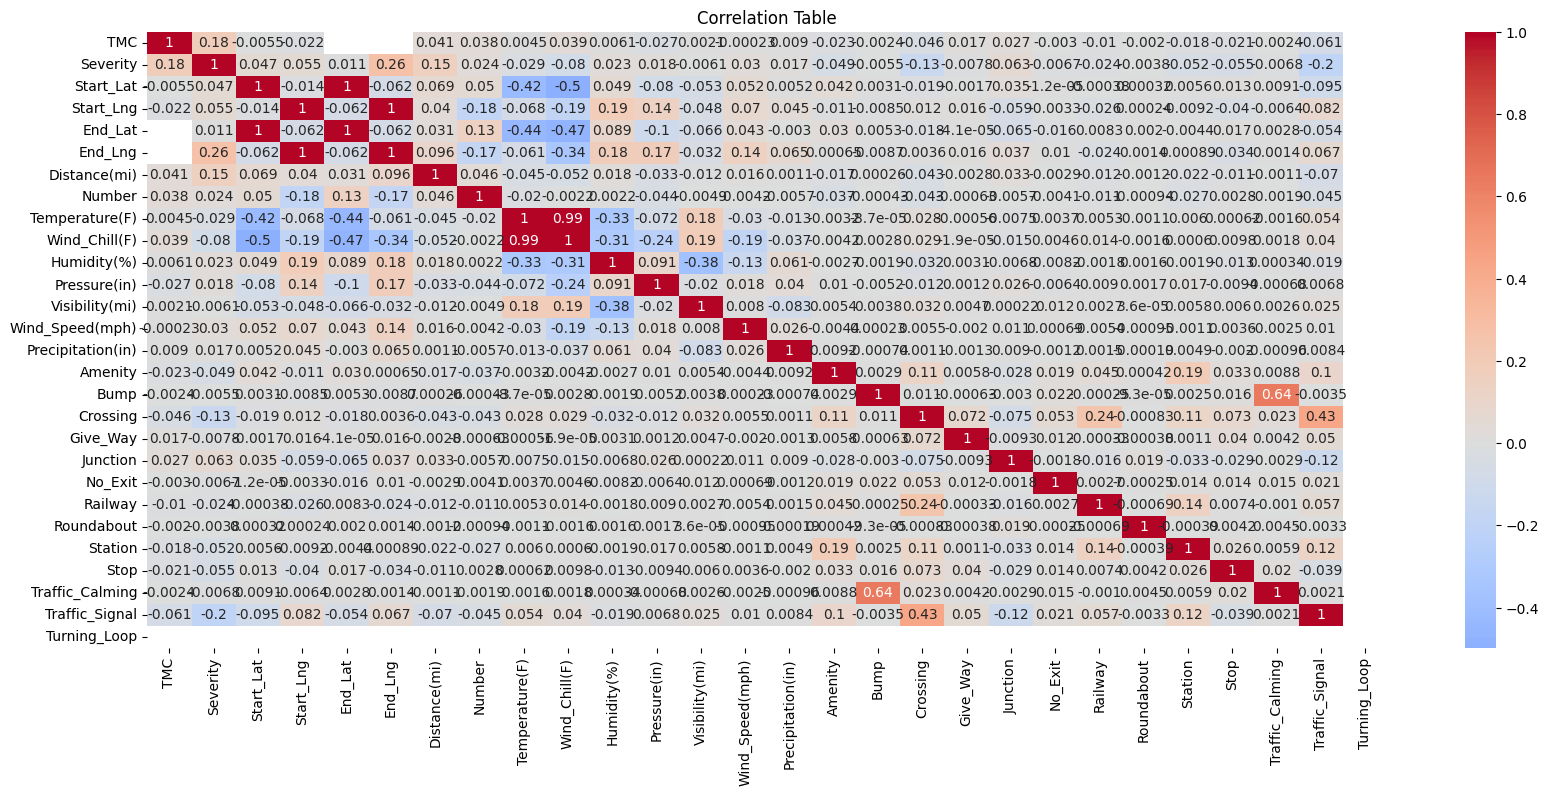

In [ ]:
accidentes_df = pd.read_csv("../../Accidente.csv")

plt.figure(figsize=(20,8))  
sns.heatmap(accidentes_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Table')
plt.show()

In [3]:
def split(df):
    train_limit = math.ceil(len(df) * 0.60)
    rem = df.shape[0] - train_limit
    val_limit = train_limit + math.ceil(rem * 0.5)
    test_limit =  val_limit + math.ceil(rem * 0.5)

    train = df[:train_limit]
    val = df[train_limit:val_limit]
    test = df[val_limit:test_limit]
    for i in train['time'].unique():
        if i in val['time'].unique():
            train = train[train['time'] != i]
            val = pd.concat([val, train[train['time'] == i]], axis=0)

    for i in val['time'].unique():
        if i in test['time'].unique():
            val = val[val['time'] != i]
            test = pd.concat([test, val[val['time'] == i]], axis=0)

    return train, test, val


df = pd.read_csv("../../accidentes-dummies-fc-no-missings-lessfeatures.csv")

print(df['Severity'].value_counts())

df['time'] = df['start_time__year'].astype(str) + "-" + df['start_time__month'].astype(str)
df = df.sort_values(by=["start_time__year", "start_time__month"])

train, test, val = split(df)

print(train['time'].unique(), val['time'].unique(), test['time'].unique())
train = train.drop(columns=["time"])
val = val.drop(columns=["time"])
test = test.drop(columns=["time"])

train.to_csv("../csv/train_data.csv")
val.to_csv("../csv/validation_data.csv")
test.to_csv("../csv/test_data.csv")

2    1918388
3     850083
4      86453
1        936
Name: Severity, dtype: int64
['2016-2' '2016-3' '2016-4' '2016-5' '2016-6' '2016-7' '2016-8' '2016-9'
 '2016-10' '2016-11' '2016-12' '2017-1' '2017-2' '2017-3' '2017-4'
 '2017-5' '2017-6' '2017-7' '2017-8' '2017-9' '2017-10' '2017-11'
 '2017-12' '2018-1' '2018-2' '2018-3' '2018-4' '2018-5' '2018-6' '2018-7'
 '2018-8' '2018-9'] ['2018-10' '2018-11' '2018-12' '2019-1' '2019-2' '2019-3' '2019-4'] ['2019-5' '2019-6' '2019-7' '2019-8' '2019-9' '2019-10' '2019-11'
 '2019-12']


In [6]:
pd.crosstab(train['start_time__month'], train['start_time__year'])
pd.crosstab(val['start_time__month'], val['start_time__year'])
pd.crosstab(test['start_time__month'], test['start_time__year'])
pd.crosstab(train['Severity'], train['start_time__year'])
pd.crosstab(val['Severity'], val['start_time__year'])
pd.crosstab(test['Severity'], test['start_time__year'])

start_time__year    2016   2017   2018
start_time__month                     
1                      0  53325  72419
2                    973  49605  69291
3                   6149  55660  72435
4                  17635  46856  70982
5                  17137  40164  74456
6                  29600  44968  62361
7                  44487  42046  64006
8                  54809  78286  74475
9                  53070  73581  71202
10                 53771  72629      0
11                 62887  67893      0
12                 57253  69383      0
start_time__year    2018   2019
start_time__month              
1                      0  77139
2                      0  72664
3                      0  67662
4                      0  71494
10                 79832      0
11                 80111      0
12                 68238      0
start_time__year     2019
start_time__month        
5                   12922
6                   63742
7                   64246
8                   72896
9         

In [3]:
selected_columns = features_selected or [
    'Distance', 'Temperature', 'Humidity', 'Pressure', 'Visibility',
    'Wind_Speed', 'Precipitation', 'Start_x', 'Start_y', 'Start_z',
    'Environment_Influence', 'start_time__year', 'start_time__month',
    'start_time__day', 'start_time__hour', 'region__west',
    'region__northeast', 'region__southwest', 'region__southeast',
    'region__midwest', 'season__winter', 'season__fall', 'quarter__q4',
    'day_part__morning', 'day_part__afternoon', 'day_part__evening',
    'day_part__night', 'wind_scale__strong_breeze',
    'wind_scale__gentle_breeze', 'wind_scale__light_breeze',
    'wind_scale__fresh_breeze', 'wind_scale__moderate_breeze',
    'weather_type__cloudy', 'weather_type__sunny', 'weather_type__rainy'
]

In [5]:
def get_train_test_val_data():
    train = pd.read_csv("../csv/train_data.csv")
    test = pd.read_csv("../csv/test_data.csv")
    val = pd.read_csv("../csv/validation_data.csv")
    train = train[selected_columns + ["Severity"]]
    test = test[selected_columns + ["Severity"]]
    val = val[selected_columns + ["Severity"]]

    x_train = train.drop(columns=["Severity"]).copy()
    y_train = train["Severity"].copy()
    encoder = preprocessing.LabelEncoder()
    encoder.fit(y_train)
    y_train = encoder.transform(y_train)

    x_test = test.drop(columns=["Severity"]).copy()
    y_test = test["Severity"].copy()
    y_test = encoder.transform(y_test)

    x_val = val.drop(columns=["Severity"]).copy()
    y_val = val["Severity"].copy()
    y_val = encoder.transform(y_val)

    return x_train, y_train, x_test, y_test, x_val, y_val


def evaluation(model, x_train, x_test, x_valid):

    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)
    pred_valid = model.predict(x_valid)

    return pred_train, pred_test, pred_valid


def model_metrics(y_train, y_test, y_valid, pred_train, pred_test, pred_valid ):
    # Accuracy
    train_accuracy = round(accuracy_score(y_train, pred_train),4)*100
    valid_accuracy = round(accuracy_score(y_valid, pred_valid),4)*100
    test_accuracy = round(accuracy_score(y_test, pred_test),4)*100

    # Accuracy Balanced
    train_accuracy_balanced = round(balanced_accuracy_score(y_train, pred_train),4)*100
    valid_accuracy_balanced = round(balanced_accuracy_score(y_valid, pred_valid),4)*100
    test_accuracy_balanced = round(balanced_accuracy_score(y_test, pred_test),4)*100

    # Precision
    train_precision = round(precision_score(y_train, pred_train, average="weighted"),4)*100
    valid_precision = round(precision_score(y_valid, pred_valid, average="weighted"),4)*100
    test_precision = round(precision_score(y_test, pred_test, average="weighted"),4)*100

    # Recall
    train_recall = round(recall_score(y_train, pred_train, average="weighted"),4)*100
    valid_recall = round(recall_score(y_valid, pred_valid, average="weighted"),4)*100
    test_recall = round(recall_score(y_test, pred_test, average="weighted"),4)*100

    # f1
    train_f1 =  f1_score(y_train, pred_train, average="weighted")*100
    valid_f1 =  f1_score(y_valid, pred_valid, average="weighted")*100
    test_f1 =  f1_score(y_test, pred_test, average="weighted")*100

    metrics_train={'accuracy':train_accuracy,
                'accuracy_balanced':train_accuracy_balanced,
                'precision':train_precision,
                'recall':train_recall,
                'f1': train_f1}

    metrics_valid={'accuracy':valid_accuracy,
                'accuracy_balanced':valid_accuracy_balanced,
                'precision':valid_precision,
                'recall':valid_recall,
                'f1': valid_f1}

    metrics_test={'accuracy':test_accuracy,
                'accuracy_balanced':test_accuracy_balanced,
                'precision':test_precision,
                'recall':test_recall,
                'f1': test_f1}


    return metrics_train, metrics_valid, metrics_test

In [5]:
train = pd.read_csv("../csv/train_data.csv")
train = train[selected_columns + ["Severity"]]

x_train = train.drop(columns=["Severity"]).copy()
y_train = train["Severity"].copy()

encoder = preprocessing.LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)

cv = StratifiedKFold(n_splits=5)
clf = RandomForestClassifier(random_state=random_state, max_features="sqrt") 
bayes_cv_tuner = BayesSearchCV(
    estimator=clf,
    search_spaces={
        'max_depth': Integer(2, 22),
        'n_estimators': Integer(50, 500),
        'min_samples_split': Integer(10,200)
    },
    scoring='accuracy',
    cv=cv,
    n_jobs=1,
    n_iter=500,
    verbose=0,
    optimizer_kwargs={'base_estimator': 'GP'},
    random_state=random_state
)

result_model = bayes_cv_tuner.fit(
    x_train, 
    y_train, 
    callback=[DeadlineStopper(20*5), DeltaXStopper(0.0001)]
)


In [6]:
model = result_model.best_estimator_
joblib.dump(model, "../models/severity-random_forest_model.sav")

['../models/severity-random_forest_model.sav']

In [5]:
model = joblib.load("../models/severity-random_forest_model.sav")
print(model)

RandomForestClassifier(max_depth=19, min_samples_split=157, n_estimators=162,
                       random_state=546565)


In [6]:
model = joblib.load("../models/severity-random_forest_model.sav")
x_train, y_train, x_test, y_test, x_val, y_val = get_train_test_val_data()
pred_train, pred_test, pred_valid = evaluation(model, x_train, x_test, x_val)
metrics_train, metrics_valid, metrics_test = model_metrics(y_train, y_test, y_val, pred_train, pred_test, pred_valid)
metrics_train, metrics_valid, metrics_test

/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with

({'accuracy': 77.68,
  'accuracy_balanced': 38.879999999999995,
  'precision': 77.75999999999999,
  'recall': 77.68,
  'f1': 75.5307317453361},
 {'accuracy': 73.74000000000001,
  'accuracy_balanced': 34.53,
  'precision': 71.91,
  'recall': 73.74000000000001,
  'f1': 71.14007508595702},
 {'accuracy': 73.56,
  'accuracy_balanced': 33.050000000000004,
  'precision': 72.46000000000001,
  'recall': 73.56,
  'f1': 72.32951338667479})

In [7]:
target_names = ["severity=1", "severity=2", "severity=3", "severity=4"]
report = classification_report(y_train, pred_train, target_names=target_names)
print("Classification Report - Train:\n", report)
report = classification_report(y_test, pred_test, target_names=target_names)
print("Classification Report - Test:\n", report)
report = classification_report(y_val, pred_valid, target_names=target_names)
print("Classification Report - Valid:\n", report)

/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defi

Classification Report - Train:
               precision    recall  f1-score   support

  severity=1       0.00      0.00      0.00       699
  severity=2       0.77      0.94      0.85   1102076
  severity=3       0.79      0.52      0.63    553891
  severity=4       0.72      0.10      0.17     52615

    accuracy                           0.78   1709281
   macro avg       0.57      0.39      0.41   1709281
weighted avg       0.78      0.78      0.76   1709281



/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report - Test:
               precision    recall  f1-score   support

  severity=1       0.00      0.00      0.00       123
  severity=2       0.81      0.85      0.83    426333
  severity=3       0.46      0.42      0.44    129986
  severity=4       0.60      0.04      0.08     14730

    accuracy                           0.74    571172
   macro avg       0.47      0.33      0.34    571172
weighted avg       0.72      0.74      0.72    571172



/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report - Valid:
               precision    recall  f1-score   support

  severity=1       0.00      0.00      0.00       102
  severity=2       0.76      0.90      0.83    347234
  severity=3       0.63      0.43      0.51    148822
  severity=4       0.57      0.05      0.09     16953

    accuracy                           0.74    513111
   macro avg       0.49      0.35      0.36    513111
weighted avg       0.72      0.74      0.71    513111



/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
x_train, y_train, x_test, y_test, x_val, y_val = get_train_test_val_data()

cv = StratifiedKFold(n_splits=5)
bayes_cv_tuner = BayesSearchCV(
    LinearSVC(class_weight= "balanced"),
    {'C': Real(1e-3, 1e+3, prior='log-uniform')},
    cv=cv,
    n_iter=500,
    scoring='accuracy',
    optimizer_kwargs={'base_estimator': 'GP'},
    random_state=random_state
)

result_model = bayes_cv_tuner.fit(
    x_train, 
    y_train, 
    callback=[DeadlineStopper(20*5), DeltaXStopper(0.0001)]
)


/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/svm

In [6]:
model = result_model.best_estimator_
joblib.dump(model, "../models/severity-linear_svc.sav")

['../models/severity-linear_svc.sav']

In [6]:
model = joblib.load("../models/severity-linear_svc.sav")
print(model)

LinearSVC(C=128.79558707316846, class_weight='balanced')


In [5]:
model = joblib.load("../models/severity-linear_svc.sav")
x_train, y_train, x_test, y_test, x_val, y_val = get_train_test_val_data()
pred_train, pred_test, pred_valid = evaluation(model, x_train, x_test, x_val)
metrics_train, metrics_valid, metrics_test = model_metrics(y_train, y_test, y_val, pred_train, pred_test, pred_valid)
metrics_train, metrics_valid, metrics_test

({'accuracy': 56.00000000000001,
  'accuracy_balanced': 35.39,
  'precision': 60.12,
  'recall': 56.00000000000001,
  'f1': 49.56113853521923},
 {'accuracy': 57.089999999999996,
  'accuracy_balanced': 34.43,
  'precision': 62.839999999999996,
  'recall': 57.089999999999996,
  'f1': 52.58265264762235},
 {'accuracy': 61.419999999999995,
  'accuracy_balanced': 34.75,
  'precision': 61.62,
  'recall': 61.419999999999995,
  'f1': 59.62259620279768})

In [6]:
target_names = ["severity=1", "severity=2", "severity=3", "severity=4"]
report = classification_report(y_train, pred_train, target_names=target_names)
print("Classification Report - Train:\n", report)
report = classification_report(y_test, pred_test, target_names=target_names)
print("Classification Report - Test:\n", report)
report = classification_report(y_val, pred_valid, target_names=target_names)
print("Classification Report - Valid:\n", report)

Classification Report - Train:
               precision    recall  f1-score   support

  severity=1       0.00      0.01      0.00       699
  severity=2       0.69      0.84      0.76   1102076
  severity=3       0.47      0.00      0.01    553891
  severity=4       0.09      0.56      0.15     52615

    accuracy                           0.56   1709281
   macro avg       0.31      0.35      0.23   1709281
weighted avg       0.60      0.56      0.50   1709281

Classification Report - Test:
               precision    recall  f1-score   support

  severity=1       0.00      0.02      0.00       123
  severity=2       0.79      0.80      0.79    426333
  severity=3       0.12      0.00      0.00    129986
  severity=4       0.07      0.57      0.12     14730

    accuracy                           0.61    571172
   macro avg       0.24      0.35      0.23    571172
weighted avg       0.62      0.61      0.60    571172

Classification Report - Valid:
               precision    recall  

In [5]:
x_train, y_train, x_test, y_test, x_val, y_val = get_train_test_val_data()

cv = StratifiedKFold(n_splits=5)
knn = KNeighborsClassifier()
param = {"n_neighbors": Integer(2,22), "algorithm": ['auto']}

bayes_cv_tuner = BayesSearchCV(
    knn, 
    param, 
    cv=cv, 
    n_iter=500, 
    scoring='neg_mean_squared_error', 
    optimizer_kwargs={'base_estimator': 'GP'}, 
    random_state=random_state
)

result_model = bayes_cv_tuner.fit(
    x_train, 
    y_train, 
    callback=[DeadlineStopper(20*5), DeltaXStopper(0.0001)]
)

In [6]:
model = result_model.best_estimator_
joblib.dump(model, "../models/severity-knn.sav")

['../models/severity-knn.sav']

In [7]:
model = joblib.load("../models/severity-knn.sav")
print(model)

KNeighborsClassifier(n_neighbors=18)


In [5]:
model = joblib.load("../models/severity-knn.sav")
x_train, y_train, x_test, y_test, x_val, y_val = get_train_test_val_data()
pred_train, pred_test, pred_valid = evaluation(model, x_train, x_test, x_val)
metrics_train, metrics_valid, metrics_test = model_metrics(y_train, y_test, y_val, pred_train, pred_test, pred_valid)
metrics_train, metrics_valid, metrics_test

/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with

({'accuracy': 69.84,
  'accuracy_balanced': 32.16,
  'precision': 68.47999999999999,
  'recall': 69.84,
  'f1': 65.8339768382227},
 {'accuracy': 65.39,
  'accuracy_balanced': 28.02,
  'precision': 60.77,
  'recall': 65.39,
  'f1': 61.457205257052415},
 {'accuracy': 68.36,
  'accuracy_balanced': 27.55,
  'precision': 65.4,
  'recall': 68.36,
  'f1': 66.24809871979667})

In [9]:
target_names = ["severity=1", "severity=2", "severity=3", "severity=4"]
report = classification_report(y_train, pred_train, target_names=target_names)
print("Classification Report - Train:\n", report)
report = classification_report(y_test, pred_test, target_names=target_names)
print("Classification Report - Test:\n", report)
report = classification_report(y_val, pred_valid, target_names=target_names)
print("Classification Report - Valid:\n", report)

/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defi

Classification Report:
               precision    recall  f1-score   support

  severity=1       0.00      0.00      0.00       699
  severity=2       0.71      0.92      0.80   1102076
  severity=3       0.63      0.32      0.43    553891
  severity=4       0.67      0.04      0.08     52615

    accuracy                           0.70   1709281
   macro avg       0.50      0.32      0.33   1709281
weighted avg       0.68      0.70      0.66   1709281



/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

  severity=1       0.00      0.00      0.00       123
  severity=2       0.77      0.84      0.80    426333
  severity=3       0.31      0.25      0.28    129986
  severity=4       0.38      0.01      0.02     14730

    accuracy                           0.68    571172
   macro avg       0.36      0.28      0.28    571172
weighted avg       0.65      0.68      0.66    571172



/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

  severity=1       0.00      0.00      0.00       102
  severity=2       0.71      0.86      0.78    347234
  severity=3       0.41      0.24      0.30    148822
  severity=4       0.36      0.02      0.03     16953

    accuracy                           0.65    513111
   macro avg       0.37      0.28      0.28    513111
weighted avg       0.61      0.65      0.61    513111



/mnt/c/Users/alexc/Documents/uade/Inteligencia-Artificial/Trabajo-práctico-1/tp1_src/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
